In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Read and Prepare Data

In [3]:
panel_data = pd.read_pickle('./data/yahoo.pkl')
panel_data

<class 'pandas.core.panel.Panel'>
Dimensions: 6 (items) x 1764 (major_axis) x 4 (minor_axis)
Items axis: Adj Close to Volume
Major_axis axis: 2016-12-30 00:00:00 to 2009-12-30 00:00:00
Minor_axis axis: AAPL to ^GSPC

In [5]:
panel_data.axes

[Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object'),
 DatetimeIndex(['2016-12-30', '2016-12-29', '2016-12-28', '2016-12-27',
                '2016-12-23', '2016-12-22', '2016-12-21', '2016-12-20',
                '2016-12-19', '2016-12-16',
                ...
                '2010-01-13', '2010-01-12', '2010-01-11', '2010-01-08',
                '2010-01-07', '2010-01-06', '2010-01-05', '2010-01-04',
                '2009-12-31', '2009-12-30'],
               dtype='datetime64[ns]', name='Date', length=1764, freq=None),
 Index(['AAPL', 'F', 'MSFT', '^GSPC'], dtype='object')]

In [7]:
# Set start and end dates
start_date = panel_data.axes[1][-1]
end_date = panel_data.axes[1][0]
start_date, end_date

(Timestamp('2009-12-30 00:00:00'), Timestamp('2016-12-30 00:00:00'))

In [12]:
# Prepare 'Close' data
close = panel_data.loc['Close']
weekdays = pd.date_range(start = start_date, end = end_date, freq='B')
close = close.reindex(weekdays)
close = close.fillna(method = 'ffill')
close.head(10)

,AAPL,F,MSFT,^GSPC
2009-12-30,30.234285,9.99,30.959999,1126.420044
2009-12-31,30.104286,10.00,30.480000,1115.099976
2010-01-01,30.104286,10.00,30.480000,1115.099976
2010-01-04,30.572857,10.28,30.950001,1132.989990
2010-01-05,30.625713,10.96,30.959999,1136.520020
2010-01-06,30.138571,11.37,30.770000,1137.140015
2010-01-07,30.082857,11.66,30.450001,1141.689941
2010-01-08,30.282858,11.69,30.660000,1144.979980
2010-01-11,30.015715,12.11,30.270000,1146.979980
2010-01-12,29.674286,11.87,30.070000,1136.219971


## Moving Average

When calculating the *M* days moving average, the first *M−1* are not valid, as *M* prices are required for the first moving average data point.

In [14]:
short_rolling = close.rolling(window = 20).mean()
short_rolling.head()

,AAPL,F,MSFT,^GSPC
2009-12-30,NaN,NaN,NaN,NaN
2009-12-31,NaN,NaN,NaN,NaN
2010-01-01,NaN,NaN,NaN,NaN
2010-01-04,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN


In [15]:
short_rolling.tail()

,AAPL,F,MSFT,^GSPC
2016-12-26,113.649,12.5770,61.8880,2241.979004
2016-12-27,113.939,12.6005,61.9975,2245.190002
2016-12-28,114.251,12.6150,62.1340,2247.745496
2016-12-29,114.613,12.6050,62.3190,2250.654492
2016-12-30,114.909,12.5995,62.4635,2252.998499


In [17]:
long_rolling = close.rolling(window = 100).mean()

## General considerations about trading strategies

There are several ways one can go about when a trading strategy is to be developed. One approach would be to use the price time-series directly and work with numbers that correspond to some monetary value. For example, a researcher could be working with time-series expressing the price of a given stock, like the time-series we used in the previous article. Similarly, if working with fixed income instruments, e.g. bonds, one could be using a time-series expressing the price of the bond as a percentage of a given reference value, in this case the par value of the bond. Working with this type of time-series can be more intuitive as people are used to thinking in terms of prices. However, price time-series have some drawbacks. Prices are usually only positive, which makes it harder to use models and approaches which require or produce negative numbers. In addition, price time-series are usually non-stationary, that is their statistical properties are less stable over time.

An alternative approach is to use time-series which correspond not to actual values but changes in the monetary value of the asset. These time-series can and do assume negative values and also, their statistical properties are usually more stable than the ones of price time-series. The most frequently used forms used are relative returns defined as
$$r_{relative}(t) = \frac{p(t) - p(t-1)}{p(t-1)}$$
and log-returns defined as
$$r(t) = \log(\frac{p(t)}{p(t-1)})$$
where $p(t)$ is the price of the asset at time $t$. For example, if $p(t)$ = 101 and $p(t-1) = 100$, then $r_{relative}(t) = \frac{101 - 100}{100} = 1\%$

There are several reasons why log-returns are being used in the industry and some of them are related to long-standing assumptions about the behaviour of asset returns and are out of our scope. However, what we need to point out are two quite interesting properties. Log-returns are additive and this facilitates treatment of our time-series, relative returns are not. We can see the additivity of log-returns in the following equation.
$$r(t_1) + r(t_2) = \log(\frac{p(t_1)}{p(t_0)}) + \log(\frac{p(t_2)}{p(t_1)}) = \log(\frac{p(t_2)}{p(t_0)})$$

which is simply the log-return from $t_0$ to $t_2$. Secondly, log-returns are approximately equal to the relative returns for values of $\frac{p(t)}{p(t-1)}$ sufficiently close to 1. By taking the 1st order Taylor expansion of $\log⁡(\frac{p(t)}{p(t−1)})$ around 1, we get
$$\log(\frac{p(t)}{p(t-1)}) \simeq \log(1) + \frac{p(t)}{p(t-1)} - 1 = r_{relative}(t)$$

In [18]:
# Relative returns
relative_returns = close.pct_change(1)
relative_returns.head()

,AAPL,F,MSFT,^GSPC
2009-12-30,NaN,NaN,NaN,NaN
2009-12-31,-0.004300,0.001001,-0.015504,-0.010050
2010-01-01,0.000000,0.000000,0.000000,0.000000
2010-01-04,0.015565,0.028000,0.015420,0.016043
2010-01-05,0.001729,0.066148,0.000323,0.003116


In [20]:
# log returns
log_returns = np.log(close).diff()
log_returns.head()

,AAPL,F,MSFT,^GSPC
2009-12-30,NaN,NaN,NaN,NaN
2009-12-31,-0.004309,0.001001,-0.015625,-0.010100
2010-01-01,0.000000,0.000000,0.000000,0.000000
2010-01-04,0.015445,0.027615,0.015302,0.015916
2010-01-05,0.001727,0.064052,0.000323,0.003111


Since log-returns are additive, we can create the time-series of cumulative log-returns defined as
$$c(t) = \sum_{k = 1}^{t}r(t)$$

And the total relative return is
$$c_{relative}(t)=\frac{p(t)–p(t_0)}{p(t_0)}$$

The cumulative log-returns and the total relative returns from 2010/01/04 for the three time-series can be seen below. Note that although log-returns are easy to manipulate, investors are accustomed to using relative returns. For example, a log-return of $1$ does not mean an investor has doubled the value of his portfolio (just because we use natural logarithm, but not log_2). A relative return of $1=100\%$ does! Converting between the cumulative log-return and the total relative return  is simple
$$c_{relative}(t)=e^{c(t)}–1$$

For those who are wondering if this is correct, yes it is. If someone had bought \$1000 worth of AAPL shares in January 2010, her/his portfolio would now be worth over \$3,000. And for Microsoft, the total relative return is roughly 1, meaning the stock price per share is doubled from 2010 to 2016, which can also be seen from the previous notebook (from \$30 to \$60).

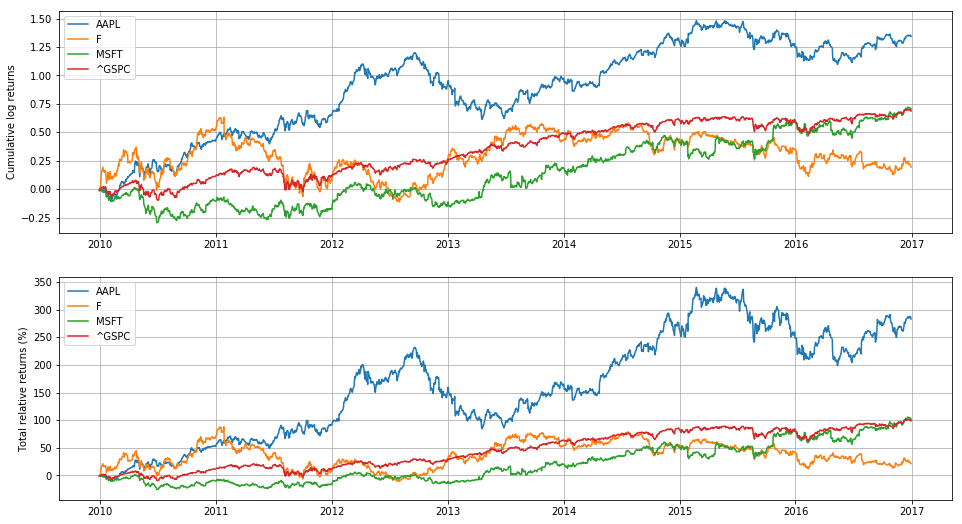

In [35]:
fig = plt.figure(figsize = [16, 9])
ax = fig.add_subplot(2, 1, 1)

for c in log_returns:
    ax.plot(log_returns.index, log_returns[c].cumsum(), label = c)
    
ax.set_ylabel('Cumulative log returns')
ax.legend(loc = 'best')
ax.grid()

ax = fig.add_subplot(2, 1, 2)
# Use the coversion formula to calculate total relative return from cumulative log return
for c in log_returns:
    ax.plot(log_returns.index, 100*(np.exp(log_returns[c].cumsum()) - 1), label = c)

ax.set_ylabel('Total relative returns (%)')
ax.legend(loc = 'best')
ax.grid()

plt.show()

## What is a Quantitative Trading Strategy?

Our goal is to develop a toy trading strategy, but what does the term “quantitative trading strategy” actually mean? In this section we will give a definition that will guide us in our long-term goal.

Assume we have at our disposal a certain amount of dollars, $N$, which we are interested to invest. We have at our disposal a set of $K$ assets from which we can buy and sell freely any arbitrary amount. Our goal is to derive weights $w_i(t)$, $i=1,\cdots,K$ such that
$$w_i(t) \in \mathbb{R} \quad \text{and} \quad \sum_{i = 1}^{K}w_i(t) \leq 1$$
so that an amount of dollars equal to $w_i(t)N$ is invested at time $t$ on asset $i$.

Note that since we have allowed $w_i(t)$ to be any real number, we are implying that we are allowed to have negative weights. Negative weights imply that we have sold a given asset **_short_**. Selling short an asset means selling an asset we do not currently hold and receiving its value in cash. Selling short is different than selling an asset we already own, which is called selling **_long_**.

The mechanics behind this can be complicated and are usually subject to regulatory scrutiny. However, on a high level, it involves borrowing the asset from a third party and then selling it to the buyer. Since at some point the asset needs to be returned to the party from which it was borrowed, the short position needs to be closed. This is achieved by buying the asset back from the original buyer or any other willing seller. For the purpose of this article it will be assumed that selling an asset short can be accomplished at no added cost, an assumption which is not true.

The assuming that the weights can be unbounded is not realistic. For example, based on the definition given above we could sell short an amount of AAPL shares of value equal to $N$. This means that, for now, we have at our disposal an additional $N$ dollars to invest from the short sale. Thus, together with our original $N$ dollars, we can the purchase shares of MSFT worth $2N$ dollars. In our framework, this translates to $w_{AAPL}=−1$ and $w_{MSFT}=2$. In theory, the weights could be $−999$ and $1000$ respectively. However, an increase in the absolute values of the weights leads to an increase in the risk of our portfolio for reasons we will see further down this series of tutorials. Therefore, when developing our trading strategy, appropriate thresholds will be imposed on the weights $w_i(t)$.

A final note has to do with cash. Any portfolio will at some point in time include cash. In the aforementioned setup if at any point in time $W=\sum^K_{i=1}w_i(t)<1$, then it means that our portfolio includes $(1−W)N$ dollars in cash. Of course, if $W<0$, our net position is short, which means we are currently holding more than $N$ dollars which is the initial value of the portfolio.



## Putting it All Together

For the remaining of this series of tutorials we will assume (unless explicitly stated) that $N=\$1$. This will allow us to simplify the notation and all calculations and only deal with the weights $w_i(t)$ of the strategy which will be pure numbers. We can always convert back to a monetary value by simply multiplying our dimensionless weights with $N$, the value of the portfolio in dollars (or any other currency of interest). We will also **assume that daily returns of the different assets are small enough, so that log-returns are roughly equal to relative returns**. Thus, in what follows we will be using the log-returns.

Assume that somehow we have what we think is a promising strategy, which is simply a vector
$$w(t) = [w_1(t), w_2(t), \cdots, w_K(t)]^T \in \mathbb{R}^{K\times1}$$

Then, if $r(t)$ is a column vector of relative returns for the assets in the portfolio, the total log-return $r_p(t)$ for each $t$ is simply
$$r_p(t) = w^T(t)r(t) = w_1(t)r_1(t) + \cdots + w_K(t)r_K(t)$$

(But actually, from my opinion, such a summation is quite questionable mathematically. For example, even if $r_i(t) = r_j(t)$, it only means their ratios between two prices are the same, but their stock prices can be very different, e.g., one stock rises from \$10 to \$20, while the other rises from \$100 to \$200. But in the summation , they are treated with no difference. The summation does make sense for relative returns, because it directly reflects the amount earned by the investor.)

Let us assume we are are using the last day in our dataset and $w_i = \frac{1}{4}, \forall i \in \{1, 2, 3, 4\}$. Then:

In [36]:
r_t = log_returns.tail(1).transpose()
r_t

,2016-12-30 00:00:00
AAPL,-0.007826
F,-0.008210
MSFT,-0.012156
^GSPC,-0.004648


In [37]:
weights_vector = pd.DataFrame(1 / 3, index = r_t.index, columns = r_t.columns)
weights_vector

,2016-12-30 00:00:00
AAPL,0.333333
F,0.333333
MSFT,0.333333
^GSPC,0.333333


In [39]:
# Total log_return for the porfolio
portfolio_log_return = weights_vector.transpose().dot(r_t)
portfolio_log_return

,2016-12-30 00:00:00
2016-12-30,-0.010947


If computer memory is not an issue, a very fast way of computing the portfolio returns for all days, $t=1,\cdots,T$ is the following:

Assume that $\mathbf{R} \in \mathbb{R}^{T×K}$ is a matrix, the $t$-th row of which is the row vector $r(t)^T$. Similarly, $\mathbf{W}\in \mathbb{ℝ}^{T×K}$ is a matrix, the $t$-th row of which is the row vector $w(t)^T$. Then 
$$r_p = diag\{\mathbf{W}\mathbf{R}^T\}$$
where $diag\{A\}$ is the diagonal of a matrix $\mathbf{A}$. The diagonal extraction is required because only in the diagonal the weights and log-returns vectors are properly time-aligned.

## An example

To illustrate the concepts of the previous section, let us consider a very simple trading strategy, where the investor splits his investments equally among all four assets we have been looking at.

In [40]:
weights_matrix = pd.DataFrame(1/3, index = close.index, columns = close.columns)
weights_matrix.head()

,AAPL,F,MSFT,^GSPC
2009-12-30,0.333333,0.333333,0.333333,0.333333
2009-12-31,0.333333,0.333333,0.333333,0.333333
2010-01-01,0.333333,0.333333,0.333333,0.333333
2010-01-04,0.333333,0.333333,0.333333,0.333333
2010-01-05,0.333333,0.333333,0.333333,0.333333


In [41]:
log_returns.head()

,AAPL,F,MSFT,^GSPC
2009-12-30,NaN,NaN,NaN,NaN
2009-12-31,-0.004309,0.001001,-0.015625,-0.010100
2010-01-01,0.000000,0.000000,0.000000,0.000000
2010-01-04,0.015445,0.027615,0.015302,0.015916
2010-01-05,0.001727,0.064052,0.000323,0.003111


In [43]:
# WR
temp_var = weights_matrix.dot(log_returns.transpose())
temp_var.head().iloc[:, 0:5]

,2009-12-30 00:00:00,2009-12-31 00:00:00,2010-01-01 00:00:00,2010-01-04 00:00:00,2010-01-05 00:00:00
2009-12-30,NaN,-0.009678,0.0,0.02476,0.023071
2009-12-31,NaN,-0.009678,0.0,0.02476,0.023071
2010-01-01,NaN,-0.009678,0.0,0.02476,0.023071
2010-01-04,NaN,-0.009678,0.0,0.02476,0.023071
2010-01-05,NaN,-0.009678,0.0,0.02476,0.023071


In [44]:
# Diagonal
porfolio_log_returns = pd.Series(np.diag(temp_var), index = temp_var.index)
porfolio_log_returns.head()

2009-12-30         NaN
2009-12-31   -0.009678
2010-01-01    0.000000
2010-01-04    0.024760
2010-01-05    0.023071
Freq: B, dtype: float64

Note that these returns are only estimates because of our use of log-returns instead of relative returns. However, for most practical purposes the difference is negligible. Let us see what our cumulative log returns and the total relative returns for this portfolio look.

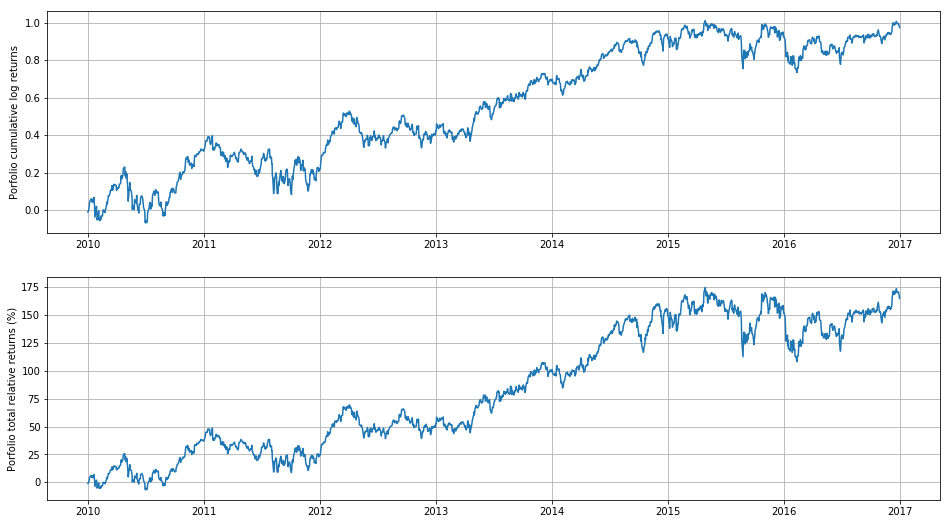

In [45]:
total_relative_returns = (np.exp(porfolio_log_returns.cumsum()) - 1)

fig = plt.figure(figsize = [16, 9])
ax = fig.add_subplot(2, 1, 1)
ax.plot(porfolio_log_returns.index, porfolio_log_returns.cumsum())
ax.set_ylabel('Porfolio cumulative log returns')
ax.grid()
ax = fig.add_subplot(2, 1, 2)
ax.plot(total_relative_returns.index, 100 * total_relative_returns)
ax.set_ylabel('Porfolio total relative returns (%)')
ax.grid()
plt.show()